####Лабораторная работа №5,Вариант №4

***Задание:*** Используя *явную и неявную конечно-разностные схемы*, а также *схему Кранка - Николсона*, решить начально-краевую задачу для дифференциального уравнения параболического типа.
Осуществить реализацию трех вариантов аппроксимации граничных условий, содержащих производные: *двухточечная аппроксимация с первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная аппроксимация со вторым порядком.*
В различные моменты времени вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением u(x, t). Исследовать зависимость погрешности от сеточных параметров tau и h.

In [1]:
import matplotlib.pyplot as plt
import sys
import warnings
import numpy as np
from functools import reduce
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def phi_0(t, a = 1.0):
    return np.exp(-a*t)

def phi_l(t, a = 1.0):
    return -np.exp(-a*t)

def u_0(x):
    return np.sin(x)

#Истинное решение
def u(x, t, a = 1.0):
    return np.exp(-a*t)*np.sin(x)

In [3]:
class Schema:
    def __init__(self, a = 1, f0 = phi_0, fl = phi_l, u0 = u_0, 
                 O = 0.5, l0 = 0, l1 = np.pi, T = 5, aprx_cls = None):
        self.fl = lambda t: fl(t, a)
        self.f0 = lambda t: f0(t, a)
        self.u0 = u0
        self.T = T
        self.l0 = l0
        self.l1 = l1
        self.tau = None
        self.h = None
        self.a = a
        self.O = O
        self.approx = None
        if aprx_cls is not None:
            self._init_approx(aprx_cls)
        self.sigma = None
        
    def _init_approx(self, a_cls):
        self.approx = a_cls(self.f0, self.fl)
    
    def set_approx(self, aprx_cls):
        self._init_approx(self, aprx_cls)
        
    def set_l0_l1(self, l0, l1):
        self.l0 = l0
        self.l1 = l1
        
    def set_T(self, T):
        self.T = T
        
    def _compute_h(self, N):
        self.h = (self.l1 - self.l0) / N
        
    def _compute_tau(self, K):
        self.tau = self.T / K
        
    def _compute_sigma(self):
        self.sigma = self.a * self.tau / (self.h * self.h)
      
    @staticmethod
    def nparange(start, end, step = 1):
        now = start
        e = 0.00000000001
        while now - e <= end:
            yield now
            now += step
        
    def _compute_line(self, t, x, last_line):
        pass
    
    def __call__(self, N=30, K=110):
        N, K = N-1, K-1
        self._compute_tau(K)
        self._compute_h(N)
        self._compute_sigma()
        ans = []
        x = list(self.nparange(self.l0, self.l1, self.h))
        last_line = list(map(self.u0, x))
        ans.append(list(last_line))
        X = []
        Y = []
        X.append(x)
        Y.append([0.0 for _ in x])
        for t in self.nparange(self.tau, self.T, self.tau):
            ans.append(self._compute_line(t, x, last_line))
            X.append(x)
            Y.append([t for _ in x])
            last_line = ans[-1]
        return X, Y, ans

In [4]:
#Явная схема
class Explict_schema(Schema):
    def _compute_sigma(self):
        self.sigma = self.a * self.tau / (self.h * self.h)
        if self.sigma > 0.5:
            warnings.warn("Sigma > 0.5")
        
    def _compute_line(self, t, x, last_line):
        line = [None for _ in last_line]
        for i in range(1, len(x) - 1):
            line[i] = self.sigma*last_line[i-1] 
            line[i] += (1 - 2*self.sigma)*last_line[i]
            line[i] += self.sigma*last_line[i+1]
        line[0] = self.approx.explict_0(t, self.h, self.sigma, 
                                        last_line, line, t - self.tau)
        line[-1] = self.approx.explict_l(t, self.h, self.sigma, 
                                         last_line, line, t - self.tau)
        return line

In [5]:
#Схема Кранка_Николсона
class Explict_Implict(Schema):
    def set_O(self, O):
        self.O = O
    
    @staticmethod
    def three_diagonal(A, b):
        P = [-item[2] for item in A]
        Q = [item for item in b]
    
        P[0] /= A[0][1]
        Q[0] /= A[0][1]
    
        for i in range(1, len(b)):
            z = (A[i][1] + A[i][0] * P[i-1])
            P[i] /= z
            Q[i] -= A[i][0] * Q[i-1]
            Q[i] /= z
    
        x = [item for item in Q]

        for i in range(len(x) - 2, -1, -1):
            x[i] += P[i] * x[i + 1]

        return x
    
    def _compute_line(self, t, x, last_line):
        a = self.sigma * self.O
        b = -1 - 2 * self.sigma * self.O
        
        A = [(a, b, a) for _ in range(1, len(x)-1)]
        w = [
            -(last_line[i] + 
                (1 - self.O) * self.sigma*
                (last_line[i-1] - 2*last_line[i] + last_line[i+1])) 
            for i in range(1, len(x)-1)
        ]
        koeffs = self.approx.nikolson_0(t, self.h, self.sigma, 
                                        last_line, self.O, t - self.tau)
        A.insert(0, koeffs[:-1])
        w.insert(0, koeffs[-1])
        koeffs = self.approx.nikolson_l(t, self.h, self.sigma, 
                                        last_line, self.O, t - self.tau)
        A.append(koeffs[:-1])
        w.append(koeffs[-1])
        
        return self.three_diagonal(A, w)

In [6]:
Krank_Nikolson = Explict_Implict

In [7]:
#Аппроксимация производных
class Derivative_approx:
    def __init__(self, f0, fl):
        self.f0 = f0
        self.fl = fl
        
    def explict_0(self, t, h, sigma, l0, l1, t0):
        pass
    def explict_l(self, t, h, sigma, l0, l1, t0):
        pass
    
    def nikolson_0(self, t, h, sigma, l0, O, t0):
        pass
    def nikolson_l(self, t, h, sigma, l0, O, t0):
        pass

In [8]:
#Двухточечная аппроксимация
class Approx_two_one(Derivative_approx):
    def explict_0(self, t, h, sigma, l0, l1, t0):
        return -h * self.f0(t) + l1[1]
    
    def explict_l(self, t, h, sigma, l0, l1, t0):
        return h * self.fl(t) + l1[-2]
    
    def nikolson_0(self, t, h, sigma, l0, O, t0):
        return 0, -1, 1, h*self.f0(t)
    
    def nikolson_l(self, t, h, sigma, l0, O, t0):
        return -1, 1, 0, h*self.fl(t)

In [9]:
#Трехточечная аппрокисмация второго порядка
class Approx_three_two(Derivative_approx):
    def explict_0(self, t, h, sigma, l0, l1, t0):
        return (-2*h*self.f0(t) + 4*l1[1] - l1[2]) / 3
                
    def explict_l(self, t, h, sigma, l0, l1, t0):
        return (2*h*self.fl(t) + 4*l1[-2] - l1[-3]) / 3
    
    def nikolson_0(self, t, h, sigma, l0, O, t0):
        d = 2*sigma*O*h*self.f0(t)
        d -= l0[1] + (1 - O)*sigma*(l0[0] - 2*l0[1] + l0[2])
        return 0, -2*sigma*O, 2*sigma*O - 1, d
    
    def nikolson_l(self, t, h, sigma, l0, O, t0):
        d = 2*sigma*O*h*self.fl(t)
        d += l0[-2] + (1 - O)*sigma*(l0[-3] - 2*l0[-2] + l0[-1])
        return 1 - 2*sigma*O, 2*sigma*O, 0, d

In [10]:
#Двухточечная аппрокисмация второго порядка
class Approx_two_two(Derivative_approx):
    def explict_0(self, t, h, sigma, l0, l1, t0):
        return -2*sigma*h*self.f0(t0) + \
                    2*sigma*l0[1] + (1 - 2*sigma)*l0[0]
                
    def explict_l(self, t, h, sigma, l0, l1, t0):
        return 2*sigma*h*self.fl(t0) + \
                    2*sigma*l0[-2] + (1 - 2*sigma)*l0[-1]
    
    def nikolson_0(self, t, h, sigma, l0, O, t0):
        d = 2*sigma*O*h*self.f0(t) - l0[0]
        d -= 2*(1 - O)*sigma*(l0[1] - l0[0] - h*self.f0(t0))
        return 0, -(2*sigma*O + 1), 2*sigma*O, d
    
    def nikolson_l(self, t, h, sigma, l0, O, t0):
        d = -2*sigma*O*h*self.fl(t) - l0[-1]
        d -= 2*(1 - O)*sigma*(l0[-2] - l0[-1] + h*self.fl(t0))
        return 2*sigma*O, -(2*sigma*O + 1), 0, d

#### Явная схема

#### Cетка для истинного решения

In [11]:
def real_z(l0, l1, T, f):
    x = np.arange(l0, l1 + 0.005, 0.005)
    y = np.arange(0, T + 0.005, 0.005)
    X = np.ones((y.shape[0], x.shape[0]))
    Y = np.ones((x.shape[0], y.shape[0]))
    Z = np.ones((y.shape[0], x.shape[0]))
    for i in range(Y.shape[0]):
        Y[i] = y
    Y = Y.T
    for i in range(X.shape[0]):
        X[i] = x
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i, j] = f(X[i, j], Y[i, j])
    return X, Y, Z

#### Явная схема

/usr/local/lib/python3.8/dist-packages/mpl_toolkits/mplot3d/art3d.py:304: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self._segments3d = np.asanyarray(segments)


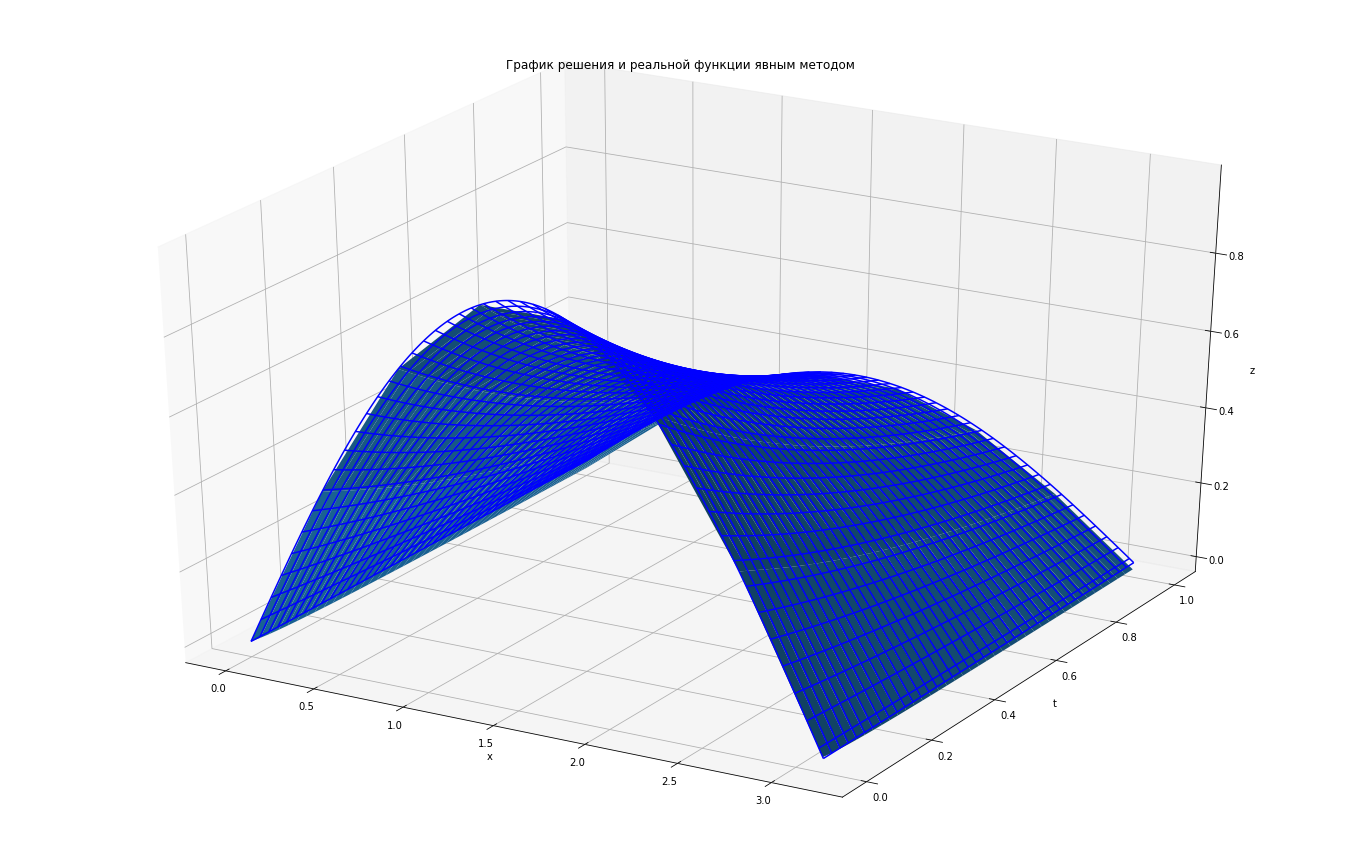

In [12]:
def Implicit_plot(a = 1):
    schema = Explict_schema(T = 1, aprx_cls=Approx_two_two, a=a)
    x, y, z = schema(N = 8, K = 40)
    fig = plt.figure(num=1, figsize=(19, 12), clear=True)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_wireframe(*real_z(0, np.pi, 1, lambda i, j: u(i, j, a)), color="blue")
    ax.plot_surface(np.array(x), np.array(y), np.array(z))
    ax.set(xlabel='x', ylabel='t', zlabel='z', title='График решения и реальной функции явным методом')
    fig.tight_layout()

Implicit_plot()
None

#### Неявная схема

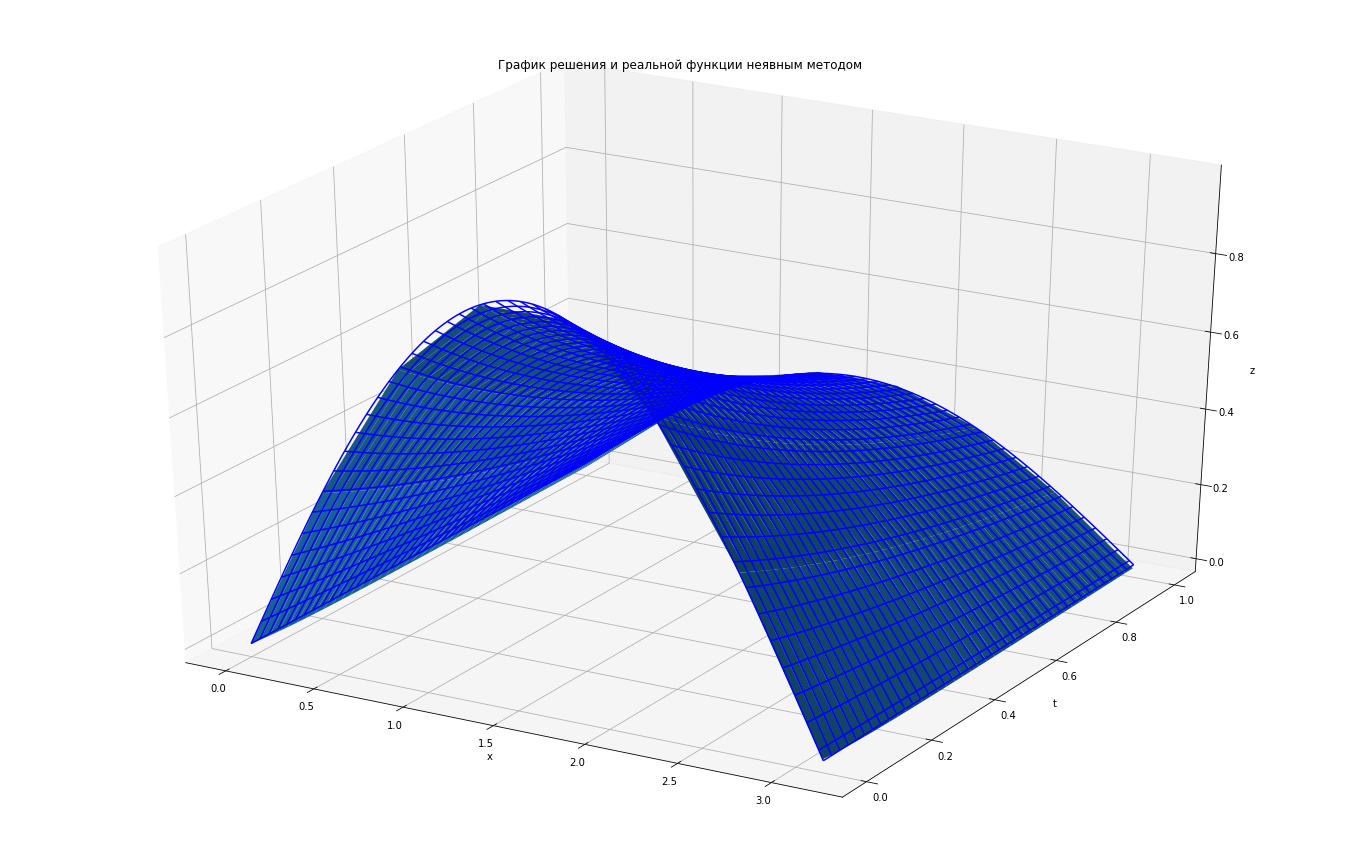

In [13]:
def Explicit_plot(a = 1):
    schema = Krank_Nikolson(T = 1, aprx_cls=Approx_two_two, a=a, O = 1)
    x, y, z = schema(N = 8, K = 40)
    fig = plt.figure(num=1, figsize=(19, 12), clear=True)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_wireframe(*real_z(0, np.pi, 1, lambda i, j: u(i, j, a)), color="blue")
    ax.plot_surface(np.array(x), np.array(y), np.array(z))
    ax.set(xlabel='x', ylabel='t', zlabel='z', title='График решения и реальной функции неявным методом')
    fig.tight_layout()

Explicit_plot()
None

#### Схема Кранка-Николсона

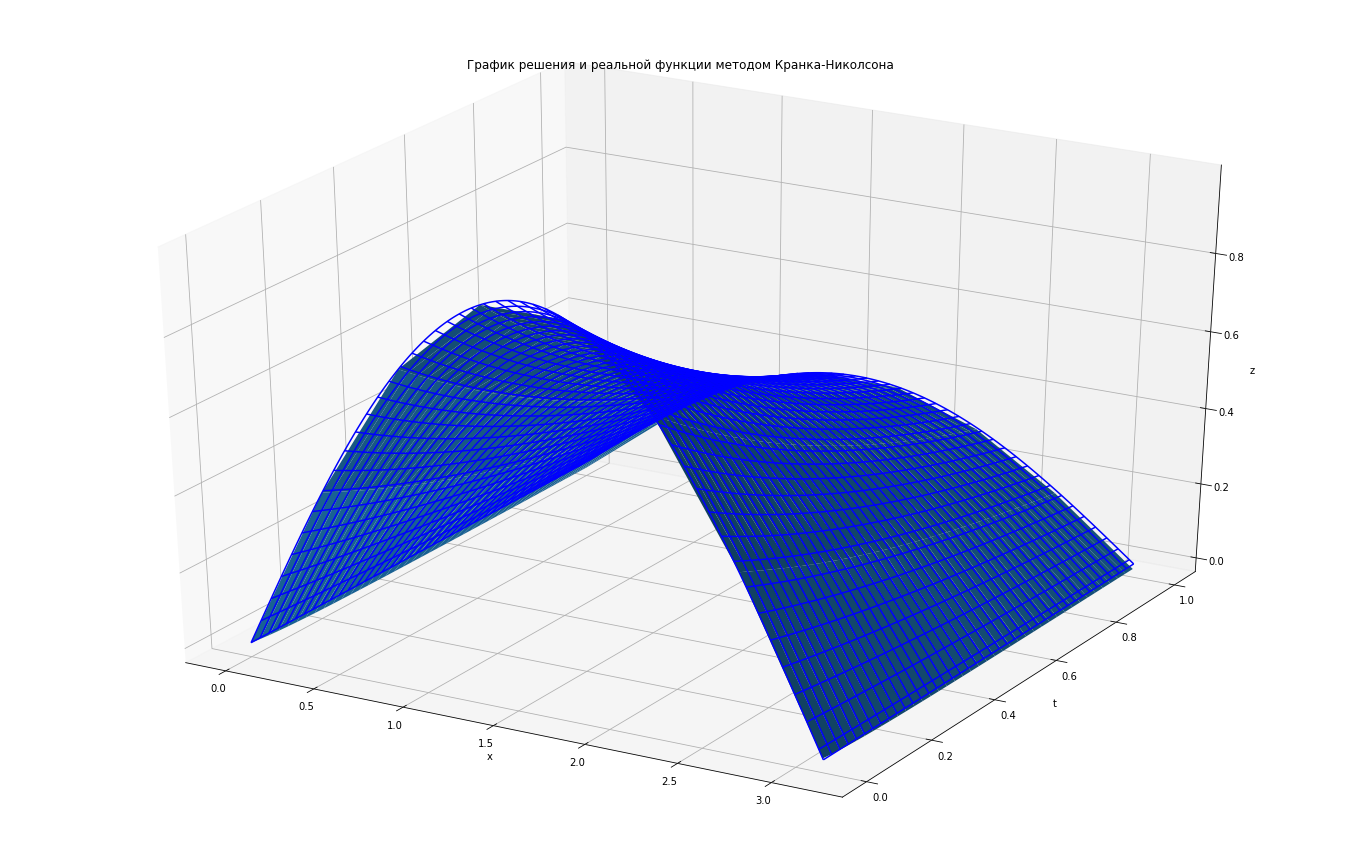

In [14]:
def Krank_Nikolson_plot(a = 1):
    schema = Krank_Nikolson(T = 1, aprx_cls=Approx_two_two, a=a, O = 0.5)
    x, y, z = schema(N = 8, K = 40)
    fig = plt.figure(num=1, figsize=(19, 12), clear=True)
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.plot_wireframe(*real_z(0, np.pi, 1, lambda i, j: u(i, j, a)), color="blue")
    ax.plot_surface(np.array(x), np.array(y), np.array(z))
    ax.set(xlabel='x', ylabel='t', zlabel='z', title='График решения и реальной функции методом Кранка-Николсона')
    fig.tight_layout()
    plt.show()


Krank_Nikolson_plot()
None

Зависимость погрешности от параметра h

In [15]:
def epsilon(x, y, z, f):
    ans = 0.0
    for i in range(len(z)):
        for j in range(len(z[i])):
            ans += (z[i][j] - f(x[i][j], y[i][j]))**2
    return ans**0.5

In [16]:
def graphic_h(solver, real_f):
    h = []
    e = []
    for N in range(3, 50):
        x, y, z = solver(N)
        h.append(solver.h)
        e.append(epsilon(x, y, z, real_f))
    return h, e

In [17]:
explict = Explict_schema(T = 1, aprx_cls=Approx_two_two)

<ipython-input-4-892d95c35015>:6: UserWarning: Sigma > 0.5
  warnings.warn("Sigma > 0.5")


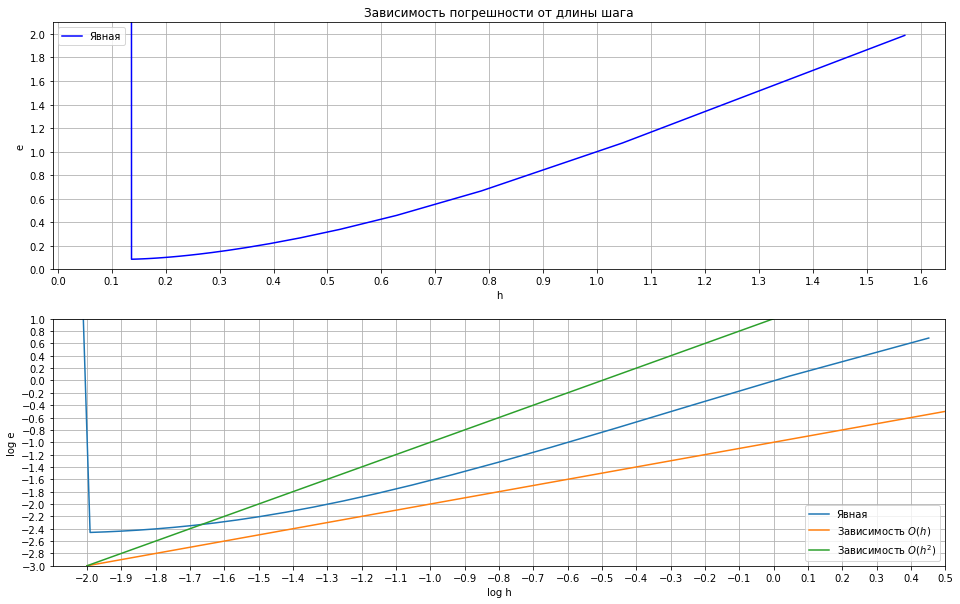

In [18]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от длины шага")
h, e = graphic_h(explict, u)

plt.plot(h, e, label="Явная", color = "blue")
plt.xlabel("h")
plt.ylabel("e")
plt.ylim([0, 2.1])
plt.xticks(list(explict.nparange(0, 1.6, 0.1)))
plt.yticks(list(explict.nparange(0, 2.1, 0.2)))
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
#График в логарифмической шкале
plt.plot(list(map(np.log, h)), list(map(np.log, e)), label="Явная")
plt.plot([-2, 0.5], [-3, -0.5], label="Зависимость $O(h)$")
plt.plot([-2, 0.5], [-3, 2], label="Зависимость $O(h^2)$")
plt.xlabel("log h")
plt.ylabel("log e")
plt.ylim([-3, 1])
plt.xlim([-2.1, 0.5])
plt.xticks(list(explict.nparange(-2, 0.5, 0.1)))
plt.yticks(list(explict.nparange(-3, 1, 0.2)))
plt.legend()
plt.grid()

Видим, что при увеличении длины шага ошибка растет

#### Неявная схема

In [19]:
implict = Krank_Nikolson(T = 1, aprx_cls=Approx_two_two, O=1)

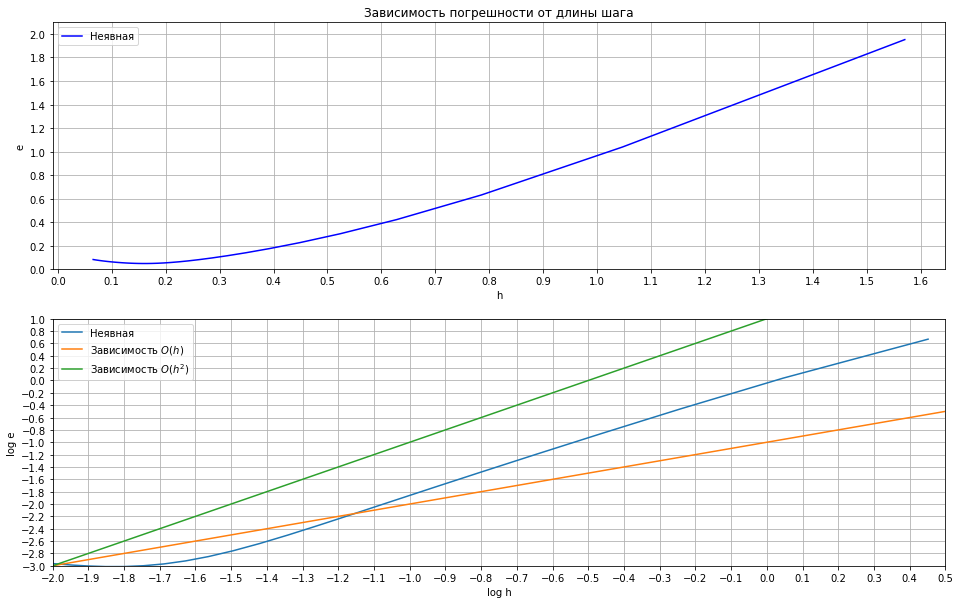

In [20]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от длины шага")
h, e = graphic_h(implict, u)

plt.plot(h, e, label="Неявная", color = "blue")
plt.xlabel("h")
plt.ylabel("e")
plt.ylim([0, 2.1])
plt.xticks(list(implict.nparange(0, 1.6, 0.1)))
plt.yticks(list(implict.nparange(0, 2.1, 0.2)))
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(np.log, h)), list(map(np.log, e)), label="Неявная")
plt.plot([-2, 0.5], [-3, -0.5], label="Зависимость $O(h)$")
plt.plot([-2, 0.5], [-3, 2], label="Зависимость $O(h^2)$")
plt.xlabel("log h")
plt.ylabel("log e")
plt.ylim([-3, 1])
plt.xlim([-2, 0.5])
plt.xticks(list(implict.nparange(-2, 0.5, 0.1)))
plt.yticks(list(implict.nparange(-3, 1, 0.2)))
plt.legend()
plt.grid()

Видим, что при увеличении длины шага ошибка растет

#### Схема Кранка-Николсона

In [21]:
krank = Krank_Nikolson(T = 1, aprx_cls=Approx_two_two)

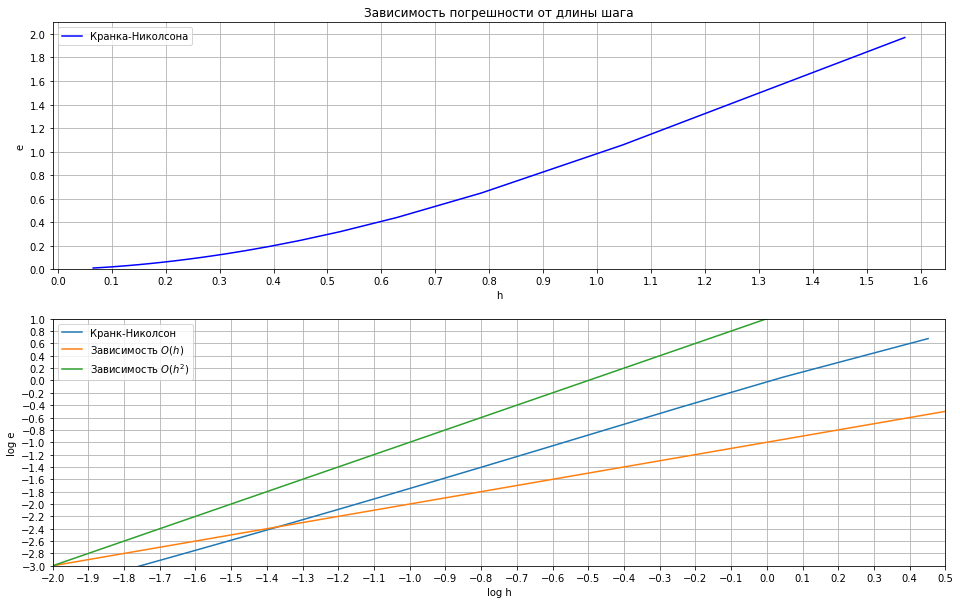

In [22]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от длины шага")
h, e = graphic_h(krank, u)

plt.plot(h, e, label="Кранка-Николсона", color = "blue")
plt.xlabel("h")
plt.ylabel("e")
plt.ylim([0, 2.1])
plt.xticks(list(krank.nparange(0, 1.6, 0.1)))
plt.yticks(list(krank.nparange(0, 2.1, 0.2)))
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(np.log, h)), list(map(np.log, e)), label="Кранк-Николсон")
plt.plot([-2, 0.5], [-3, -0.5], label="Зависимость $O(h)$")
plt.plot([-2, 0.5], [-3, 2], label="Зависимость $O(h^2)$")
plt.xlabel("log h")
plt.ylabel("log e")
plt.ylim([-3, 1])
plt.xlim([-2, 0.5])
plt.xticks(list(krank.nparange(-2, 0.5, 0.1)))
plt.yticks(list(krank.nparange(-3, 1, 0.2)))
plt.legend()
plt.grid()

####Зависимость погрешности от параметра tau

####Вычисление погрешности

In [23]:
def get_graphic_tau(solver, real_f):
    tau = []
    e = []
    for K in range(3, 90):
        x, y, z = solver(K = K)
        tau.append(solver.tau)
        e.append(epsilon(x, y, z, real_f))
    return tau, e

#### Явная схема

In [24]:
explict = Explict_schema(T = 5, aprx_cls=Approx_two_two)

<ipython-input-4-892d95c35015>:6: UserWarning: Sigma > 0.5
  warnings.warn("Sigma > 0.5")


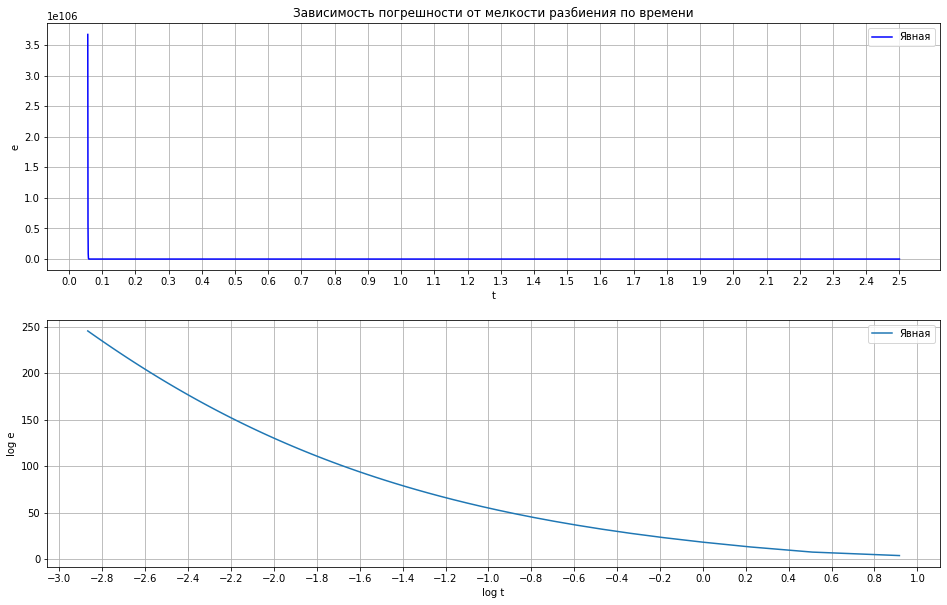

In [25]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от мелкости разбиения по времени")
tau, e = get_graphic_tau(explict, u)

plt.plot(tau, e, label="Явная", color = "blue")
plt.xlabel("t")
plt.ylabel("e")
plt.xticks(list(explict.nparange(0, 2.5, 0.1)))
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(np.log, tau)), list(map(np.log, e)), label="Явная")
plt.xlabel("log t")
plt.ylabel("log e")
plt.xticks(list(explict.nparange(-3, 1, 0.2)))
plt.legend()
plt.grid()

#### Неявная схема

In [26]:
implict = Krank_Nikolson(T = 5, aprx_cls=Approx_two_two, O=1)

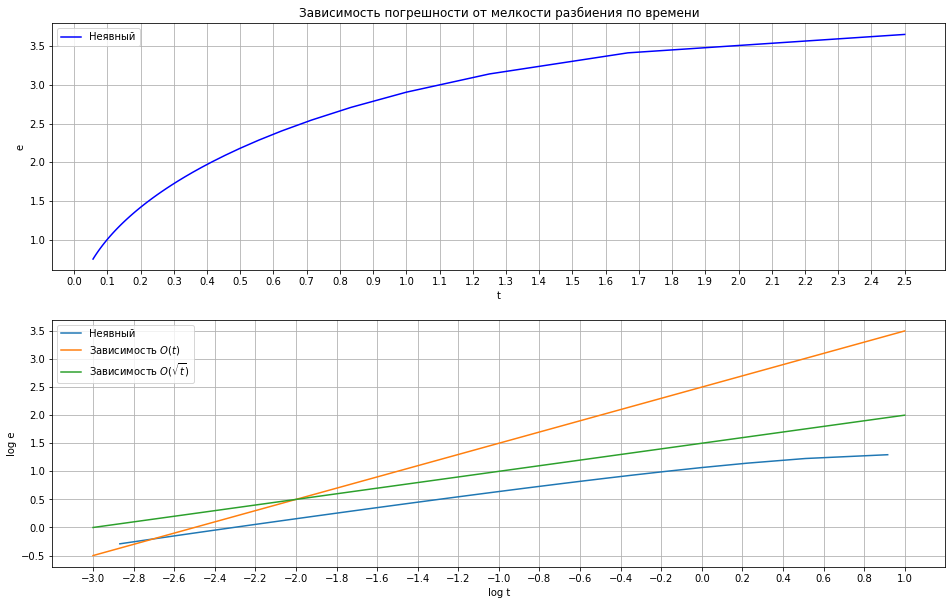

In [27]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от мелкости разбиения по времени")
tau, e = get_graphic_tau(implict, u)

plt.plot(tau, e, label="Неявный", color = "blue")
plt.xlabel("t")
plt.ylabel("e")
plt.xticks(list(explict.nparange(0, 2.5, 0.1)))
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(np.log, tau)), list(map(np.log, e)), label="Неявный")
plt.plot([-3, 1], [-0.5, 3.5], label="Зависимость $O(t)$")
plt.plot([-3, 1], [0, 2], label="Зависимость $O(\sqrt{t})$")
plt.xlabel("log t")
plt.ylabel("log e")
plt.xticks(list(explict.nparange(-3, 1, 0.2)))

plt.legend()
plt.grid()

#### Схема Кранка-Николсона

In [28]:
krank = Krank_Nikolson(T = 5, aprx_cls=Approx_two_two)

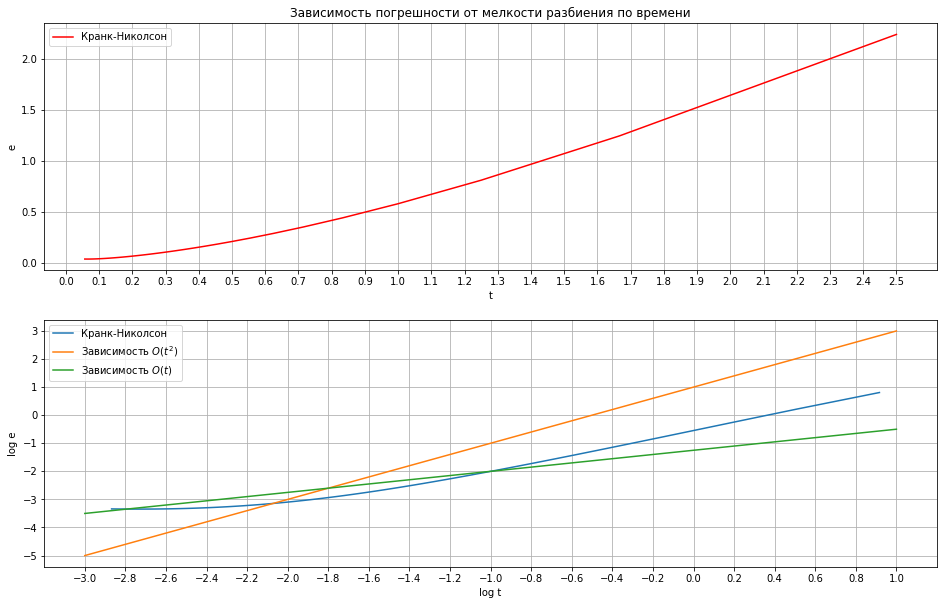

In [29]:
plt.figure(figsize = (16, 10))

plt.subplot(2, 1, 1)
plt.title("Зависимость погрешности от мелкости разбиения по времени")
tau, e = get_graphic_tau(krank, u)

plt.plot(tau, e, label="Кранк-Николсон", color = "red")
plt.xlabel("t")
plt.ylabel("e")
plt.xticks(list(krank.nparange(0, 2.5, 0.1)))
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(list(map(np.log, tau)), list(map(np.log, e)), label="Кранк-Николсон")
plt.plot([-3, 1], [-5, 3], label="Зависимость $O(t^2)$")
plt.plot([-3, 1], [-3.5, -0.5], label="Зависимость $O(t)$")
plt.xlabel("log t")
plt.ylabel("log e")
plt.xticks(list(krank.nparange(-3, 1, 0.2)))

plt.legend()
plt.grid()

Опять же видим, что при увеличении шага погрешность растет